In [37]:
#IMPORTS
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
#__future__ is a real module, and serves three purposes:

#To avoid confusing existing tools that analyze import statements and expect to find the modules they’re importing.
#To ensure that future statements run under releases prior to 2.1 at least yield runtime exceptions.
#To document when incompatible changes were introduced, and when they will be — or were — made mandatory.

#absolute_import: imports Multi-Line and Absolute/Relative
#division: changes the Division Operator
#print_function: makes print a function
#unicode_literals: bytes literals in Python 3000

In [38]:
#IMPORTS
try:
  
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [39]:
#IMPORTS
import IPython.display as display
#Public API for display tools in IPython.

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
#Just for visual purpose

import numpy as np
import PIL.Image
#The Image module provides a class with the same name which is used to represent a PIL image. 
#The module also provides a number of factory functions, including functions to load images from files, and to create new images.
import time
#This module provides various time-related functions.
import functools
#Any callable object can be treated as a function for the purposes of this module.

In [40]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [41]:
#Download images below:

In [43]:
content_path1 = '/Users/kamil/Desktop/rick.jpg'

In [45]:
style_path1 = '/Users/kamil/Desktop/pablo.jpg'

In [46]:
#Define a function to load an image and limit dimensions to 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [47]:
#Define a function to display an image.
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

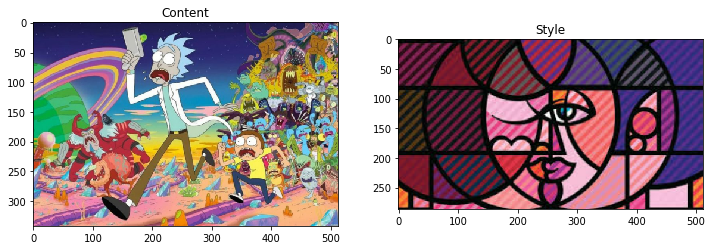

In [48]:
#Show images.
content_image = load_img(content_path1)
style_image = load_img(style_path1)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style')

In [63]:
#Load a VGG19 and test run it.
#VGG19 is a model, with weights pre-trained on ImageNet.
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [64]:
#Test run.
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('jigsaw_puzzle', 0.37011918),
 ('toyshop', 0.17595597),
 ('comic_book', 0.068698466),
 ('pinwheel', 0.06295579),
 ('coral_reef', 0.038656596)]

In [ ]:
#Above we can see VGG19 model's early predictions. 
#This is important because it tells us whether it distinguishes important parts of images.

In [65]:
#VGG19 without the classification head, list the layer names.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_9
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [66]:
# Content layer where it will pull our feature maps.
content_layers = ['block5_conv2'] 

# Style layers of interest.
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
#Cell above is super important for NST to work properly. 
#It makes sure that the network understands images good enough to be able to describe the content and style of input images.
#All of this by accessing intermediate layers of the model.

In [ ]:
#tf.keras.applications make it easy to extract intermediate layer values with Keras API.
#We define a model using the functional API: 
#model = Model(inputs, outputs).
#Function above builds a model that returns a list of intermediate layes outputs.

In [67]:
#Build a VGG19 model that returns a list of intermediate layer outputs:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data.
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [44]:
#To create model.
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#The statistics of each layer's output.
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 288, 512, 64)
  min:  0.0
  max:  852.8865
  mean:  36.70371

block2_conv1
  shape:  (1, 144, 256, 128)
  min:  0.0
  max:  4694.1416
  mean:  207.46114

block3_conv1
  shape:  (1, 72, 128, 256)
  min:  0.0
  max:  10244.484
  mean:  247.3048

block4_conv1
  shape:  (1, 36, 64, 512)
  min:  0.0
  max:  24325.096
  mean:  886.42194

block5_conv1
  shape:  (1, 18, 32, 512)
  min:  0.0
  max:  3826.255
  mean:  65.657364



In [68]:
#The content of an image is represented by the values of the intermediate feature maps.
#The style of an image can be described by the means and correlations across the different feature maps. 
#Gram matrix includes this information.
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [69]:
#Build a model that extracts the style and content tensors.
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [47]:
#Model returns the gram matrix (style) of the style_layers and content of the content_layers:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.104407966
    max:  156149.77
    mean:  912.1157

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  232634.08
    mean:  30455.098

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  716813.2
    mean:  40039.016

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  9922060.0
    mean:  345037.62

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  161182.58
    mean:  1697.7706

Contents:
   block5_conv2
    shape:  (1, 20, 32, 512)
    min:  0.0
    max:  1127.3131
    mean:  13.25828


In [ ]:
#Gradient descent
#With style and content extractor we can implement the style transfer algorithm.

In [70]:
#Style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [71]:
#Define a tf.Variable to contain the image to optimize.
image = tf.Variable(content_image)

In [72]:
#Define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [73]:
#Create an optimizer. LBFGS or Adam.
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [74]:
#Optimize
style_weight=1e-2
content_weight=1e4


In [ ]:
#To optimize, use a weighted combination of the two losses to get the total loss:

In [75]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
#tf.GrandientTape records operations for automatic differentiation.

In [76]:
#Update the image with tf.GradientTape
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

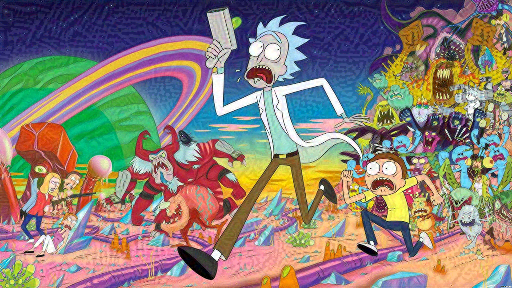

In [77]:
#Quick test
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
#We can see that our content image has a filter from style image. Perfect for now.

In [ ]:
#Import our time module.
#Set 10 epochs with 100 steps each.

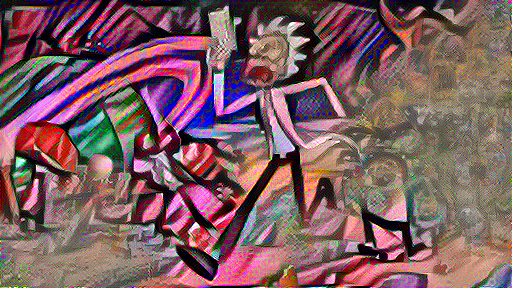

Train step: 1000
Total time: 3236.7


In [78]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
#We produced a lot of high frequency artifacts.
#We can decrease their number by performing total variation loss.

In [79]:
#Total variation loss
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

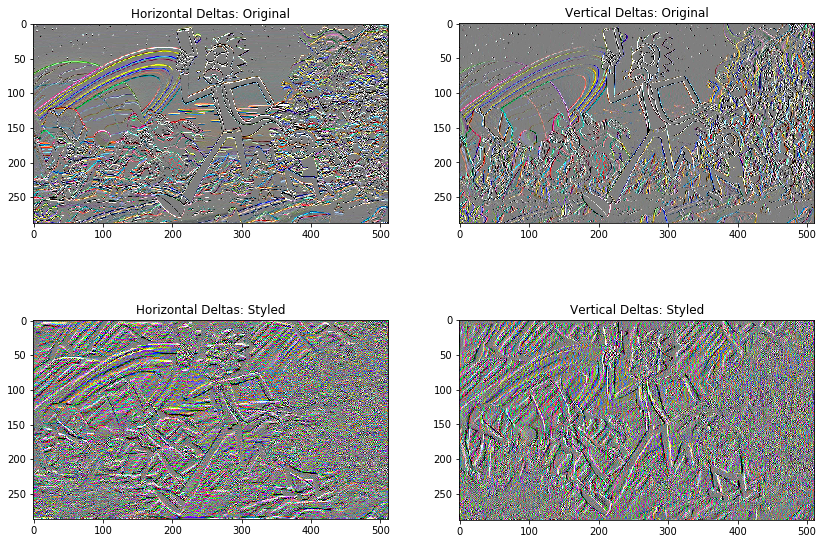

In [80]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
#Now we can see how the high frequency artifacts have increased.
#We can also use Sobel edge detector:

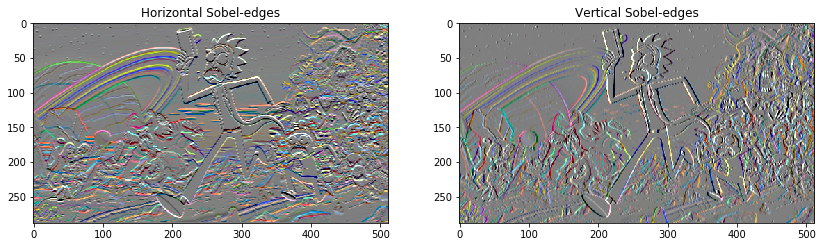

In [81]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
#The regularization loss associated with this is the sum of the squares of the values:

In [82]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [83]:
total_variation_loss(image).numpy()

103724.22

In [ ]:
#There's no need to implement it yourself, TensorFlow includes a standard implementation:

In [84]:
tf.image.total_variation(image).numpy()

array([103724.22], dtype=float32)

In [ ]:
#We can see that the values are the same.
#Now we will re-run the optimization.

In [85]:
#Choose a weight for the total_variation_loss:
total_variation_weight=30

In [ ]:
#Now we will include total_variation_weight in the train_step function:

In [86]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [87]:
image = tf.Variable(content_image)

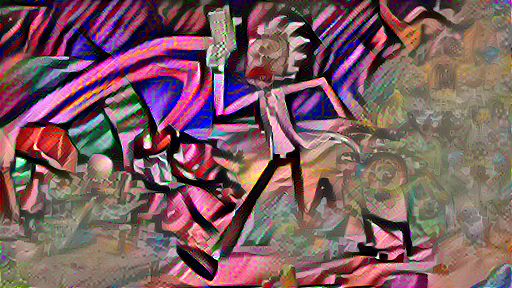

Train step: 1000
Total time: 3509.6


In [88]:
#Optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
#Save the results:

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)